# Evaluation

This notebook further explores **high-level evaluation functions**, **Data Abstraction** and **Classifiers**

* **High-level evaluation functions**
    * We demonstrate how to use ```prequential_evaluation()```, ```test_then_train_evaluation()``` and ```windowed_evaluation()```, and how to further encapsulate prequential evaluation using ```prequential_evaluation_multiple_learners```
    * We also discuss particularities about how these evaluation functions relate to how research has developed in the field, and how evaluation is commonly performed and presented.

* **Supervised Learning**
    * We clarify important information concerning the usage of **Classifiers** and their predictions
    * We added some examples using **Regressors**, which highlight the fact that the evaluation is identical to **Classifiers** (i.e. same high-level evaluation functions)
 
Complete documentation about the examples discussed in here can be found in the documentation: LINK_CAPYMOA_ORG

**last update on 12/04/2024**

In [1]:
# Classification data
arff_elec_path = '../data/electricity.arff'
csv_elec_path = '../data/electricity.csv'
# Regression
csv_fried_path = '../data/fried.csv'

## 1. The difference between Evaluators

* The following example implements an **while loop** that updates a ```ClassificationWindowedEvaluator``` and a ```ClassificationEvaluator``` for the same learner. 
* The ```ClassificationWindowedEvaluator``` update the metrics according to tumbling windows which 'forgets' old correct and incorrect predictions. This allow us to observe how well the learner performs on shorter windows. 
* The ```ClassificationEvaluator``` update the metrics taking into account all the correct and incorrect predictions made. It is useful to observe the overall performance after processing hundreds of thousands of instances.

* **Two important points**:
    1. Regarding **window_size** in ```ClassificationEvaluator```: A ```ClassificationEvaluator``` also allow us to specify a window size, but it only controls the frequency at which cumulative metrics are calculated.
    2. If we access metrics directly (not through ```metrics_per_window()```) in ```ClassificationWindowedEvaluator``` we will be looking at the metrics corresponding to the last window.
 
For further insight into the specifics of the Evaluators, please refer to the documentation: LINK_CAPYMOA_ORG

In [2]:
from capymoa.stream import stream_from_file
from capymoa.evaluation import ClassificationWindowedEvaluator, ClassificationEvaluator
from capymoa.learner.classifier import AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=csv_elec_path)

ARF = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=10)

# The window_size in ClassificationWindowedEvaluator specifies the amount of instances used per evaluation
windowedEvaluatorARF = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)
# The window_size ClassificationEvaluator just specifies the frequency at which the cumulative metrics are stored
classificationEvaluatorARF = ClassificationEvaluator(schema=stream.get_schema(), window_size=4500)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    windowedEvaluatorARF.update(instance.y_index, prediction)
    classificationEvaluatorARF.update(instance.y_index, prediction)
    ARF.train(instance)

# Showing only the 'classifications correct (percent)' (i.e. accuracy)
print(f'[ClassificationWindowedEvaluator] Windowed accuracy reported for every window_size windows')
display(windowedEvaluatorARF.metrics_per_window()[['classified instances','classifications correct (percent)']])

print(f'[ClassificationEvaluator] Cumulative accuracy: {classificationEvaluatorARF.accuracy()}')
# We could report the cumulative accuracy every window_size instances with the following code, but that is normally not very insightful. 
# display(classificationEvaluatorARF.metrics_per_window()[['classified instances','classifications correct (percent)']])

capymoa_root: /Users/gomeshe/Dropbox/ciencia_computacao/dev/main-projects/CapyMOA/src/capymoa
MOA jar path location (config.ini): /Users/gomeshe/Dropbox/ciencia_computacao/dev/main-projects/CapyMOA/src/capymoa/jar/moa.jar
JVM Location (system): 
JAVA_HOME: /Users/gomeshe/Library/Java/JavaVirtualMachines/openjdk-20.0.1/Contents/Home
JVM args: ['-Xmx8g', '-Xss10M']
Sucessfully started the JVM and added MOA jar to the class path
[ClassificationWindowedEvaluator] Windowed accuracy reported for every window_size windows


,classified instances,classifications correct (percent)
0,4500.0,89.200000
1,9000.0,89.266667
2,13500.0,89.288889
3,18000.0,87.888889
4,22500.0,87.711111
5,27000.0,85.066667
6,31500.0,85.133333
7,36000.0,86.222222
8,40500.0,87.111111
9,45000.0,88.644444


[ClassificationEvaluator] Cumulative accuracy: 87.5684145480226


## 2. High-level evaluation functions

In CapyMOA, for supervised learning, there are three primary evaluation functions designed to handle the manipulation of Evaluators. They streamline the process, ensuring users need not directly update them. Essentially, these functions execute the evaluation loop and manage the updating of Evaluators as follows: 

1. ```test_then_train_evaluation()``` -> ```ClassificationEvaluator```
2. ```windowed_evaluation()``` -> ```ClassificationWindowedEvaluator```
3. ```prequential_evaluation()``` -> ```ClassificationEvaluator``` and ```ClassificationWindowedEvaluator```

In simple terms, ```prequential_evaluation()``` combines the functionality of ```test_then_train_evaluation()``` and ```windowed_evaluation()```. In most cases, you are better off using ```prequential_evaluation()``` instead of worrying about the two other functions. We use the same functions for Regression, the functionality and interpretation are the same, but the metrics are different. 

**Result of a high-level function**
* The return from these functions is a dictionary that includes the Evaluators and some other metrics (like wall-clock and cpu time).
* The choice of a dictionary is to keep it simple and flexible.

**Common characteristics for all high-level evaluation functions**
* Each one of these functions specify a ```max_instances``` parameter, which by default is None. Depending on the source of the data (e.g. a real stream or a synthetic stream) the evaluator will never stop executing! The notion is that Streams in CapyMOA are infinite, we process them as such. Therefore, it is a good idea to specify ```max_instances``` 

**Evaluation practices in the literature (and practice)**

Interested readers might want to peruse section *6.1.1 Error Estimation* from [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book. We further expand the relationships between the literature and our evaluation functions in the documentation: LINK_CAPYMOA_ORG

### 2.1 test_then_train_evaluation()

Test then train evaluation yields cumulative results, which means the metrics are calculated based on all instances processed so far. 
Frequently in benchmark analyses, when summarizing performance metrics within a table, the figures provided typically represent cumulative results.

* The Evaluator object present in the results dictionary  (key: 'cumulative')  returned from ```test_then_train_evaluation()``` is a ```ClassificationEvaluator```
* The example below show how we can access the metrics from the results
* One can inspect the ```metrics_per_window()``` function of a ```ClassificationEvaluator``` returned from ```test_then_train_evaluation()```, however, it will not contain any value
* To avoid confusion, ```window_size``` is not a parameter for ```test_then_train_evaluation()```, even though technically someone might want to investigate the cumulative results several times. If that is desirable, we suggest using the ```ClassificationEvaluator``` directly (as shown earlier in this tutorial) while specifying the ```window_size``` of the ```ClassificationEvaluator```

In [3]:
from pprint import pprint
from capymoa.evaluation import test_then_train_evaluation

ARF = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=10)

results = test_then_train_evaluation(stream=stream, learner=ARF)

# We can see below the content of the results. Some metrics can be directly obtained, 
# such as wallclock, while others are accessible through the Evaluator (i.e. key 'cumulative')
print(f"The content of the results dictionary (wallclock = {results['wallclock']:.{2}f} seconds): ")
pprint(results)

# Common metrics, such as kappa() or accuracy(), can be accessed directly through the Evaluator object
print(f"\n~~ Cumulative kappa statistic: {results['cumulative'].kappa()} and Accuracy: {results['cumulative'].accuracy()} ~~\n")

# All other metrics can be accessed through metrics_dict() via the Evaluator: 
print('All the metrics accessible through the Evaluator: \n')
pprint(results['cumulative'].metrics_dict())

The content of the results dictionary (wallclock = 8.28 seconds): 
{'cpu_time': 8.677993,
 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator object at 0x1048027f0>,
 'learner': 'AdaptiveRandomForest',
 'max_instances': None,
 'stream': <capymoa.stream.stream.NumpyStream object at 0x1047faac0>,
 'wallclock': 8.280642032623291}

~~ Cumulative kappa statistic: 74.43350770290526 and Accuracy: 87.5684145480226 ~~

All the metrics accessible through the Evaluator: 

{'F1 Score (percent)': 87.23622588506547,
 'F1 Score for class 0 (percent)': 89.34375059117308,
 'F1 Score for class 1 (percent)': 85.08328257818499,
 'Kappa M Statistic (percent)': 70.71179743149794,
 'Kappa Statistic (percent)': 74.43350770290526,
 'Kappa Temporal Statistic (percent)': 15.26774969915763,
 'Precision (percent)': 87.43697986542071,
 'Precision for class 0 (percent)': 88.1579929814082,
 'Precision for class 1 (percent)': 86.71596674943322,
 'Recall (percent)': 87.03639164918238,
 'Recall for cla

### 2.2 windowed_evaluation()

A ```windowed_evaluation()``` update metrics per windows, which means metrics are reported based on subsets (windows) of instances. Reporting metrics per window allow us to observe how the model was performing in a particular point in time, instead of only observe an overall result. 

* The Evaluator object present in the results dictionary (key: 'windowed') returned from ```windowed_evaluation()``` is a ```WindowedClassificationEvaluator```
* The relevant results are accessible through ```metrics_per_window()``` function. 
* If the ```window_size``` does not perfectly divide ```max_instances``` (leaving no remainder in the division), the remaining instances are utilized to update a final window. This practical consideration is relevant when conducting benchmarking.
* One can access metrics directly from the ```WindowedClassificationEvaluator``` object, like ```accuracy()```, however, these contain only the results for the last window. 

The content of the results dictionary (wallclock = 8.65 seconds): 
{'cpu_time': 8.735284999999998,
 'learner': 'AdaptiveRandomForest',
 'max_instances': None,
 'stream': <capymoa.stream.stream.NumpyStream object at 0x1047faac0>,
 'wallclock': 8.647826910018921,
 'windowed': <capymoa.evaluation.evaluation.ClassificationWindowedEvaluator object at 0x1047fa0a0>}


,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),Precision (percent),Precision for class 0 (percent),Precision for class 1 (percent),Recall (percent),Recall for class 0 (percent),Recall for class 1 (percent)
0,4500.0,89.200000,77.405998,33.149931,72.480181,88.704076,91.072741,86.332958,88.643721,91.341194,85.946249,88.764512,90.805861,86.723164
1,9000.0,89.266667,78.394297,36.026490,76.644101,89.197184,90.063773,88.330515,89.192964,90.119391,88.266538,89.201404,90.008224,88.394584
2,13500.0,89.288889,78.556735,27.080182,77.581395,89.283982,89.625484,88.929720,89.262437,90.364583,88.160291,89.305537,88.898377,89.712697
3,18000.0,87.888889,74.962727,15.895062,71.118177,87.514314,89.749859,85.202281,87.800223,88.239645,87.360802,87.230261,91.312667,83.147854
4,22500.0,87.711111,73.664002,22.980501,68.633012,87.014155,90.265798,83.338355,87.987070,87.092391,88.881748,86.062521,93.679211,78.445831
5,27000.0,85.066667,68.714954,-17.482517,64.064171,84.547494,87.746171,80.887372,85.346992,84.302733,86.391252,83.762835,91.482890,76.042781
6,31500.0,85.133333,68.246645,-22.080292,61.836851,84.212374,88.148804,80.059613,84.842511,85.852312,83.832709,83.591528,90.571533,76.611523
7,36000.0,86.222222,71.097829,-4.201681,65.536409,85.569113,88.673730,82.416336,85.828438,87.522539,84.134337,85.311351,89.855609,80.767093
8,40500.0,87.111111,73.837466,13.043478,70.271656,86.928148,88.510301,85.323887,86.826815,89.395758,84.257871,87.029717,87.642213,86.417222
9,45000.0,88.644444,77.057053,27.000000,77.023381,88.544966,89.691346,87.360871,88.659401,88.530466,88.788336,88.430826,90.883074,85.978578


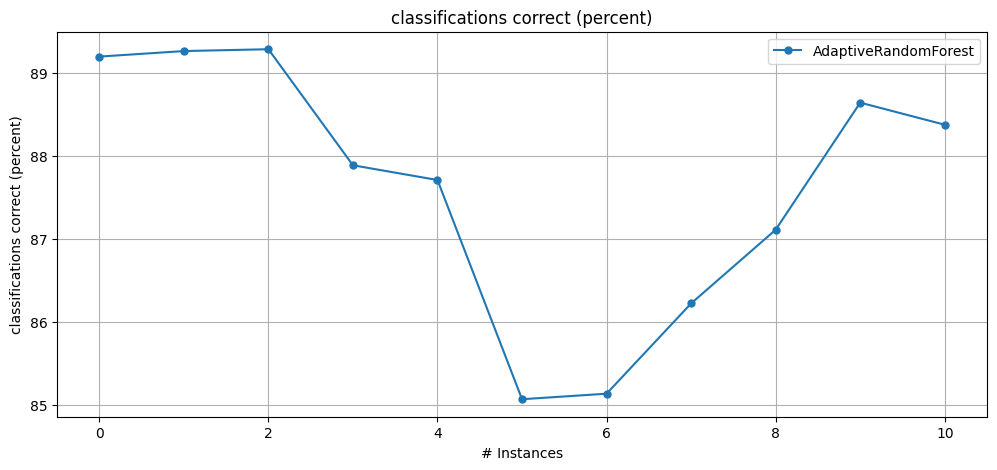

In [4]:
from pprint import pprint
from capymoa.evaluation import windowed_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

ARF = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=10)

# Notice the addition of a window_size
results = windowed_evaluation(stream=stream, learner=ARF, window_size=4500)

# We can see below the content of the results. 
# Note that some metrics can be directly obtained, such as wallclock, while others are accessible through the Evaluator
print(f"The content of the results dictionary (wallclock = {results['wallclock']:.{2}f} seconds): ")
pprint(results)

# Metric values per window are accessible as a Pandas DataFrame through metrics_per_window()
display(results['windowed'].metrics_per_window())

# When we plot the results, the plotting function uses the metrics_per_window()
plot_windowed_results(results)

### 2.3 prequential_evaluation()

A ```prequential_evaluation()``` combines ```windowed_evaluation()``` and ```test_then_train_evaluation```. Internally, it maintainsa ```ClassificationWindowedEvaluator``` and ```ClassificationEvaluator```. This allow us to have access to the **cumulative** and **windowed** results without running two separate evaluation functions. 

* The Evaluators object present in the results dictionary  and 'cumulative') returned from ```prequential_evaluation()``` are a ```ClassificationWindowedEvaluator``` (key: 'windowed') and a ```ClassificationEvaluator``` (key: 'cumulative'). 

* To investigate the ```cumulative``` results, we can access the ```metrics_dictionary```
  
* Notice that the computational overhead of training and assessing the same model twice outweights the minimum overhead of updating the two Evaluators within the function. Thus in most cases it is advisable to use the ```prequential_evaluation()``` function instead of ```windowed_evaluation()``` and ```test_then_train_evaluation``` separately. 

The content of the results dictionary (wallclock = 9.06 seconds): 
{'cpu_time': 9.338590000000003,
 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator object at 0x2d9b64070>,
 'ground_truth_y': None,
 'learner': 'AdaptiveRandomForest',
 'max_instances': None,
 'predictions': None,
 'stream': <capymoa.stream.stream.NumpyStream object at 0x1047faac0>,
 'wallclock': 9.059311151504517,
 'windowed': <capymoa.evaluation.evaluation.ClassificationWindowedEvaluator object at 0x2d8e04310>}
All the metrics accessible through the Evaluator: 

{'F1 Score (percent)': 87.23622588506547,
 'F1 Score for class 0 (percent)': 89.34375059117308,
 'F1 Score for class 1 (percent)': 85.08328257818499,
 'Kappa M Statistic (percent)': 70.71179743149794,
 'Kappa Statistic (percent)': 74.43350770290526,
 'Kappa Temporal Statistic (percent)': 15.26774969915763,
 'Precision (percent)': 87.43697986542071,
 'Precision for class 0 (percent)': 88.1579929814082,
 'Precision for class 1 (percent)': 86.7

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),Precision (percent),Precision for class 0 (percent),Precision for class 1 (percent),Recall (percent),Recall for class 0 (percent),Recall for class 1 (percent)
0,4500.0,89.200000,77.405998,33.149931,72.480181,88.704076,91.072741,86.332958,88.643721,91.341194,85.946249,88.764512,90.805861,86.723164
1,9000.0,89.266667,78.394297,36.026490,76.644101,89.197184,90.063773,88.330515,89.192964,90.119391,88.266538,89.201404,90.008224,88.394584
2,13500.0,89.288889,78.556735,27.080182,77.581395,89.283982,89.625484,88.929720,89.262437,90.364583,88.160291,89.305537,88.898377,89.712697
3,18000.0,87.888889,74.962727,15.895062,71.118177,87.514314,89.749859,85.202281,87.800223,88.239645,87.360802,87.230261,91.312667,83.147854
4,22500.0,87.711111,73.664002,22.980501,68.633012,87.014155,90.265798,83.338355,87.987070,87.092391,88.881748,86.062521,93.679211,78.445831
5,27000.0,85.066667,68.714954,-17.482517,64.064171,84.547494,87.746171,80.887372,85.346992,84.302733,86.391252,83.762835,91.482890,76.042781
6,31500.0,85.133333,68.246645,-22.080292,61.836851,84.212374,88.148804,80.059613,84.842511,85.852312,83.832709,83.591528,90.571533,76.611523
7,36000.0,86.222222,71.097829,-4.201681,65.536409,85.569113,88.673730,82.416336,85.828438,87.522539,84.134337,85.311351,89.855609,80.767093
8,40500.0,87.111111,73.837466,13.043478,70.271656,86.928148,88.510301,85.323887,86.826815,89.395758,84.257871,87.029717,87.642213,86.417222
9,45000.0,88.644444,77.057053,27.000000,77.023381,88.544966,89.691346,87.360871,88.659401,88.530466,88.788336,88.430826,90.883074,85.978578


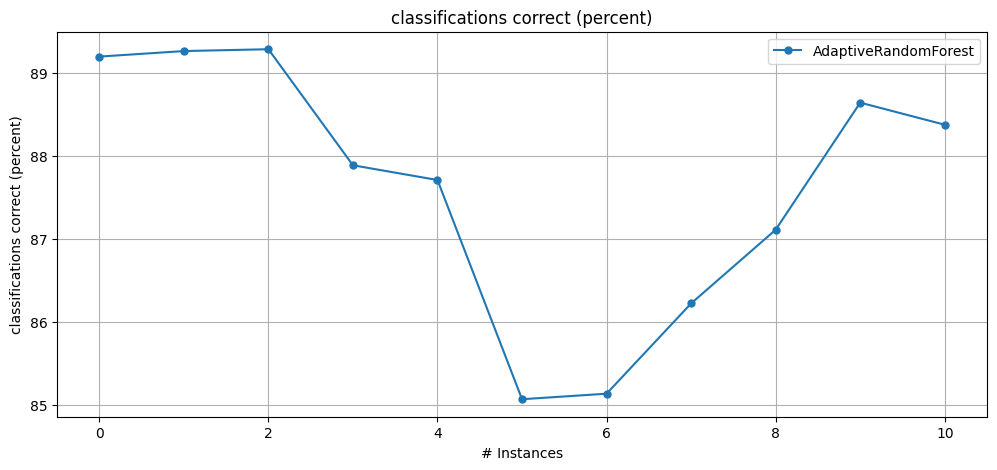

In [5]:
from capymoa.evaluation import prequential_evaluation
from capymoa.stream import stream_from_file
from capymoa.learner.classifier import OnlineBagging

ARF = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=10)

results = prequential_evaluation(stream=stream, learner=ARF, window_size=4500)

# We can see below the content of the results. 
# Note that some metrics can be directly obtained, such as wallclock, while others are accessible through the Evaluator
print(f"The content of the results dictionary (wallclock = {results['wallclock']:.{2}f} seconds): ")
pprint(results)

# All other cumulative metrics can be accessed through metrics_dict() via the Evaluator: 
print('All the metrics accessible through the Evaluator: \n')
pprint(results['cumulative'].metrics_dict())

# We can observe the cumulative results directly (as we did with test_then_train_evaluation results)... 
print(f"\n~~ [cumulative] kappa statistic: {results['cumulative'].kappa()} and accuracy: {results['cumulative'].accuracy()} ~~\n")

# ... we can also observe the other cumulative metrics through metrics_dict()
print('[cumulative] Metrics: \n')
pprint(results['cumulative'].metrics_dict())
print('\n')


# We can also inspect the windowed results... 
print('[windowed] Metrics per window:')
display(results['windowed'].metrics_per_window())

# ...and plot them
plot_windowed_results(results)

### 2.4 Evaluating a single stream using multiple learners

```prequential_evaluation_multiple_learners()``` further encapsulates experiments by executing multiple learners on a single stream. 

* This function behaves as if we invoked ```prequential_evaluation()``` multiple times, but internally it only iterates through the Stream once. This is useful if we are faced with a situation where accessing each Instance of the Stream is costly this function will be more convenient than just invoking ```prequential_evaluation()``` multiple times. 

* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved, thus timing estimations are unreliable. Thus, the results dictionaries do not contain the keys ```wallclock``` and ```cpu_time```. 

OB final accuracy = 79.15342514124293 and ARF final accuracy = 87.5684145480226


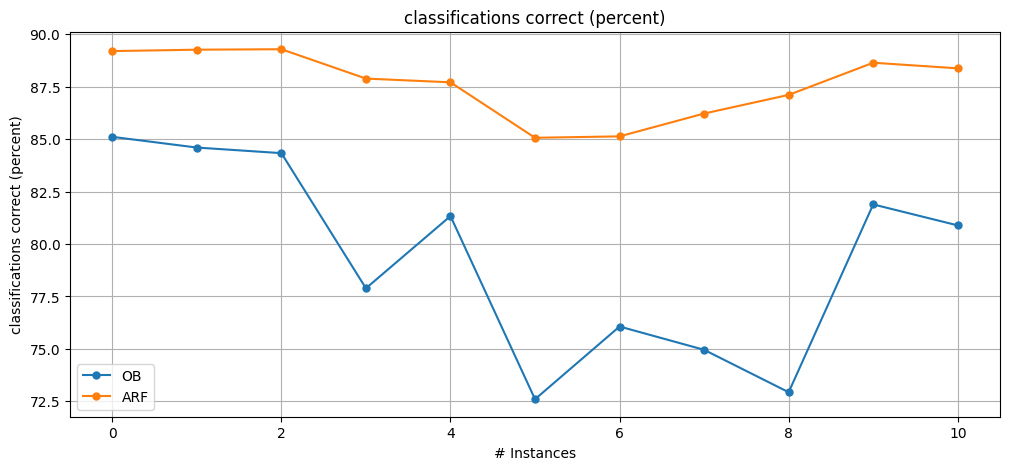

In [6]:
from capymoa.evaluation import prequential_evaluation_multiple_learners

stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

# Define the learners + an alias (dictionary key)
learners = {
    'OB': OnlineBagging(schema=stream.get_schema(), ensemble_size=10),
    'ARF': AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=10)
}

results = prequential_evaluation_multiple_learners(stream, learners, window_size=4500)

print(f"OB final accuracy = {results['OB']['cumulative'].accuracy()} and ARF final accuracy = {results['ARF']['cumulative'].accuracy()}")
plot_windowed_results(results['OB'], results['ARF'], metric="classifications correct (percent)")

## 3. Regression

* We introduce a simple example using regression just to show how similar it is to assess regressors using the **high-level evaluation functions**
* In the example below, we just use ```prequential_evaluation()``` but it would work with ```test_then_train_evaluation()``` and ```windowed_evaluation()``` as well.
* One difference between Classification and Regression evaluation in CapyMOA is that the Evaluators are different. Instead of ```ClassificationEvaluator``` and ```ClassificationWindowedEvaluator``` we should use ```RegressionEvaluator``` and ```RegressionWindowedEvaluator```

kNNRegressor [cumulative] RMSE = 2.7394543131282583 and     AdaptiveRandomForestRegressor  [cumulative] RMSE = 3.303185689295369


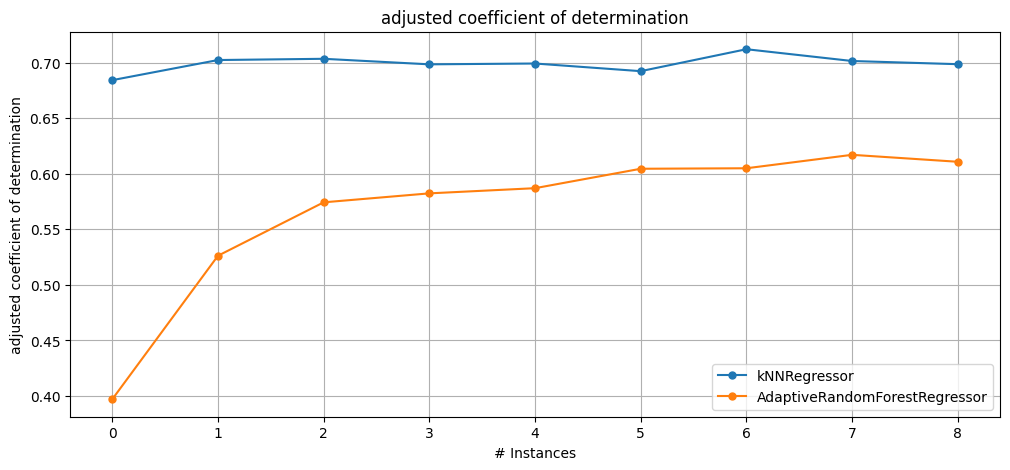

In [7]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation
from capymoa.stream import stream_from_file
from capymoa.learner.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000)
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000)

print(f"{kNN_results['learner']} [cumulative] RMSE = {kNN_results['cumulative'].RMSE()} and \
    {ARF_results['learner']}  [cumulative] RMSE = {ARF_results['cumulative'].RMSE()}")

plot_windowed_results(kNN_results, ARF_results, metric='adjusted coefficient of determination')

### 3.1 Evaluating a single stream using multiple learners (Regression)

* Similarly to what we can do with Classification, it is doable to use ```prequential_evaluation_multiple_learners``` for Regression

Cumulative results (RMSE) for each learner:
kNNReg_k5, RMSE: 2.74, adjusted R2: 0.70 
kNNReg_k2, RMSE: 3.10, adjusted R2: 0.62 
kNNReg_k5_median, RMSE: 2.96, adjusted R2: 0.65 
ARFReg_s5, RMSE: 3.74, adjusted R2: 0.44 


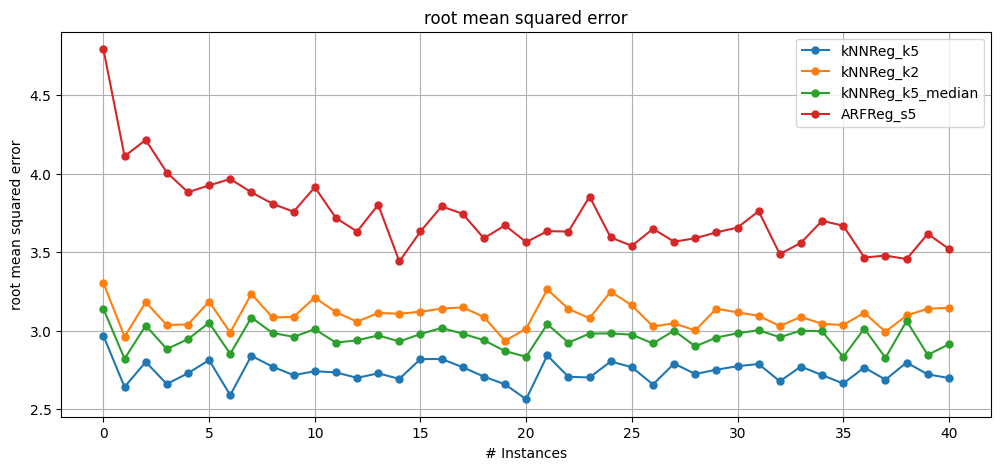

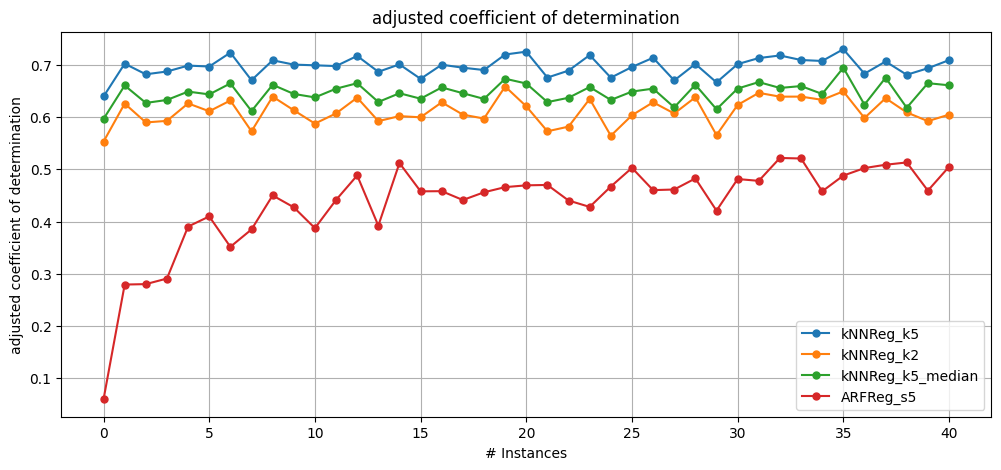

In [8]:
from capymoa.evaluation import prequential_evaluation_multiple_learners

# Define the learners + an alias (dictionary key)
learners = {
    'kNNReg_k5': KNNRegressor(schema=stream.get_schema(), k=5),
    'kNNReg_k2': KNNRegressor(schema=stream.get_schema(), k=2),
    'kNNReg_k5_median': KNNRegressor(schema=stream.get_schema(), CLI='-k 5 -m'),
    'ARFReg_s5': AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)
}

results = prequential_evaluation_multiple_learners(stream, learners)

print('Cumulative results (RMSE) for each learner:')
for learner_id in results.keys():
    print(f"{learner_id}, RMSE: {results[learner_id]['cumulative'].RMSE():.2f}, adjusted R2: {results[learner_id]['cumulative'].adjusted_R2():.2f} ")

# Tip: invoking metrics_header() from an Evaluator will show us all the metrics available, 
# e.g. results['kNNReg_k5']['cumulative'].metrics_header()
plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s5'], metric="root mean squared error")

plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s5'], metric="adjusted coefficient of determination")

### 3.2 Plotting predictions vs. ground truth over time (Regression)

In Regression it is sometimes desirable to plot **predictions vs. ground truth** to observe what is happening with the Stream. If we create a custom loop and use the Evaluators directly it is trivial to store the ground truth and predictions, and then proceed to plot them. However, to make people's life easier. 

* For massive streams with millions of instances it can be unbearable to plot all at once, thus we can specify a ```plot_interval``` that we want to investigate. By default, the plot function will attempt to plot everything, i.e. if ```plot_interval=None```

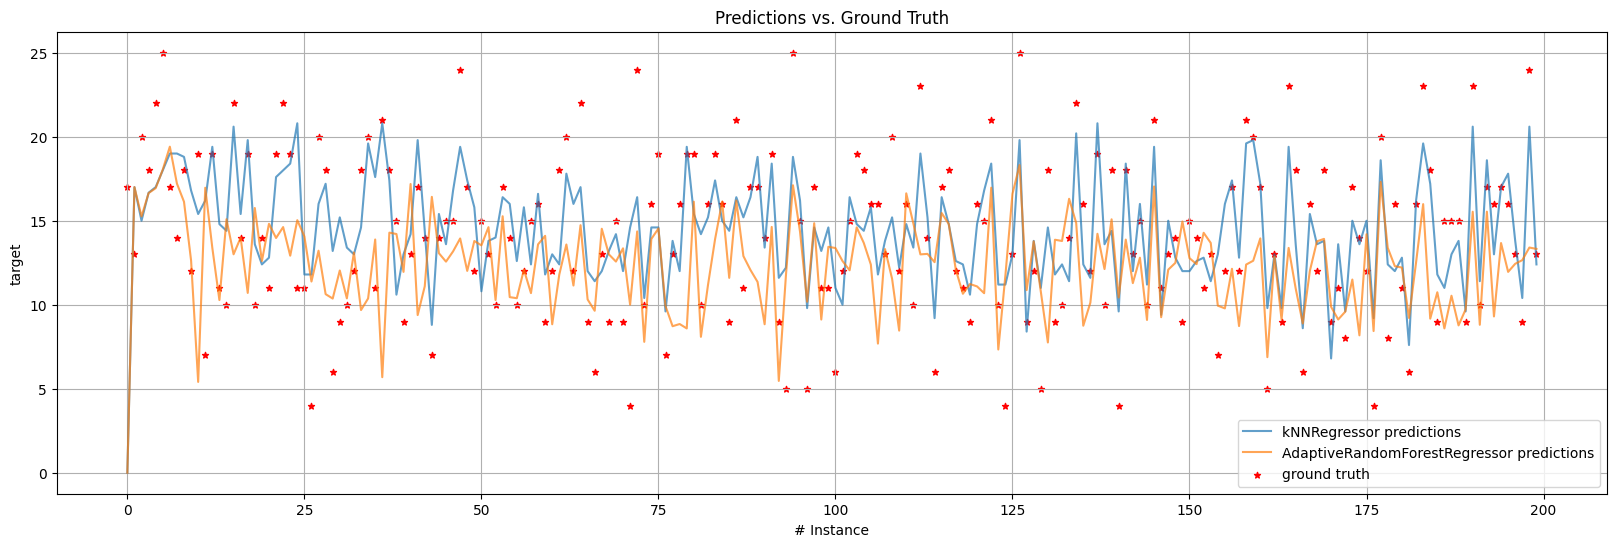

In [9]:
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_predictions_vs_ground_truth
from capymoa.learner.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

# When we specify store_predictions and store_y, the results will also include all the predictions and all the ground truth y. 
# It is useful for debugging and outputting the predictions elsewhere. 
kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000, store_predictions=True, store_y=True)
# We don't need to store the ground-truth for every experiment, since it is always the same for the same stream
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000, store_predictions=True)


# Plot only 200 predictions (see plot_interval)
plot_predictions_vs_ground_truth(kNN_results, ARF_results, ground_truth=kNN_results['ground_truth_y'], plot_interval=(0, 200))